1. Viz1: /nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220225_1734

In [248]:
path = '/nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220225_1734/checkpoints/'
saved_model_path = path +'/saved_model.pt'
saved_model_max_recall_path = path + '/saved_model_max_recall.pt'

In [277]:
take = saved_model_max_recall_path

In [278]:

import torch
saved_model = torch.load(take)

In [279]:
import math
import torch
import numpy as np
#from config import *
from misc.utils import *
import torch.nn.functional as F

class PerformancePredictor(torch.nn.Module):
    def __init__(self):
        super(PerformancePredictor, self).__init__()
        self.n_dims = 128
        self.fc = torch.nn.Linear(self.n_dims*2, 1)

    def forward(self, q, m):
        p = torch.cat([q, m], 1)
        p = torch.sigmoid(self.fc(p))
        return p

class ModelEncoder(torch.nn.Module):
    def __init__(self):
        super(ModelEncoder, self).__init__()  
        self.n_dims = 128
        self.fc = torch.nn.Linear(2048, self.n_dims) #torch.nn.Linear(45+1536, self.args.n_dims) 
            
    def forward(self, v_f):
        m = v_f
        m = F.normalize(m)
        m = self.fc(m)
        m = self.l2norm(m)
        return m

    def l2norm(self, x):
        norm2 = torch.norm(x, 2, dim=1, keepdim=True)
        x = torch.div(x, norm2)
        return x
    
class QueryEncoder(torch.nn.Module):
    def __init__(self):
        super(QueryEncoder, self).__init__()
        self.n_dims = 128
        self.fc = torch.nn.Linear(512, self.n_dims) 

    def forward(self, D):
        q = []
        for d in D:
            _q = self.fc(d) 
            _q = torch.mean(_q, 0)
            _q = self.l2norm(_q.unsqueeze(0))
            q.append(_q)
        q = torch.stack(q).squeeze()
        return q

    def l2norm(self, x):
        norm2 = torch.norm(x, 2, dim=1, keepdim=True)
        x = torch.div(x, norm2)
        return x

In [280]:

device = 'cpu'
enc_q = QueryEncoder().to(device) 
enc_q.load_state_dict(saved_model['enc_q'])
enc_m = ModelEncoder().to(device)
enc_m.load_state_dict(saved_model['enc_m'])
pred = PerformancePredictor().to(device)
pred.load_state_dict(saved_model['predictor'])

epoch = saved_model['epoch']
recall = saved_model['recall']
medr = saved_model['medr']
meanr = saved_model['meanr']
mse = saved_model['mse']

In [281]:
model_zoo_path = '/nfs/projects/mbzuai/shikhar/datasets/ofa/our_mod_zoo.pt'
data_path = '/nfs/projects/mbzuai/shikhar/datasets/ofa/our_data_path'
import os
model_zoo = torch.load(model_zoo_path)
query = torch.load(os.path.join(data_path, 'meta_train.pt'))

In [282]:
query.keys()

dict_keys(['CTPancreas', 'RSPECT', 'IHD_Brain', 'MosMed', 'ProstateMRI', 'Brain_MRI', 'ImageCHD', 'RSNAXRay', 'kits', 'Covid19XRay', 'LiTs'])

torch.stack(query['zalando-store-crawl_dqmonn_0_6']['x_query_train']).shape

In [283]:
import pandas as pd
f_model_zoo = pd.DataFrame(model_zoo)

In [284]:
f_model_zoo

,best_epoch,acc,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,46,0.826667,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,97,0.790000,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,11,0.776667,0.263736,0.507455,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,resnet18,True,False,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,16,0.708333,0.235808,0.549068,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,mobilenet_v2,True,False,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,95,0.950000,0.210526,0.150664,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,resnet50,True,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,42,0.855469,0.780415,0.259087,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,CTPancreas,efficientnet_b4,True,False,False,True,raw,"[tensor(0.0308), tensor(-0.0279), tensor(-0.01..."
323,22,0.818750,0.188811,0.089775,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,ImageCHD,mobilenet_v2,True,False,False,False,raw,"[tensor(2.0657), tensor(2.1143), tensor(1.8511..."
324,44,0.759375,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
325,88,0.531792,0.531792,1.122675,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,resnet18,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


def process_topol(topol):
    ks = topol[:20] 
    e = topol[20:40]
    d = topol[40:]
    tmp = torch.zeros(len(ks))
    for stage, num_layer in enumerate(d):
        tmp[stage*4:stage*4+num_layer] = 1
    ks = torch.tensor(ks) * tmp
    e = torch.tensor(e) * tmp
    topol = [int(t) for t in [*ks.tolist(), *e.tolist(), *d]]
    return topol

In [285]:
set(model_zoo['dataset'])

{'Brain_MRI',
 'CTPancreas',
 'Covid19XRay',
 'IHD_Brain',
 'ImageCHD',
 'LiTs',
 'MosMed',
 'ProstateMRI',
 'RSNAXRay',
 'RSPECT',
 'kits'}

In [304]:
pd.DataFrame(model_zoo)

,best_epoch,acc,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,46,0.826667,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,97,0.790000,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,11,0.776667,0.263736,0.507455,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,resnet18,True,False,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,16,0.708333,0.235808,0.549068,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,mobilenet_v2,True,False,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,95,0.950000,0.210526,0.150664,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,resnet50,True,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,42,0.855469,0.780415,0.259087,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,CTPancreas,efficientnet_b4,True,False,False,True,raw,"[tensor(0.0308), tensor(-0.0279), tensor(-0.01..."
323,22,0.818750,0.188811,0.089775,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,ImageCHD,mobilenet_v2,True,False,False,False,raw,"[tensor(2.0657), tensor(2.1143), tensor(1.8511..."
324,44,0.759375,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
325,88,0.531792,0.531792,1.122675,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,resnet18,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [311]:
z = pd.DataFrame(model_zoo)
set(z[z['f1']>0.55]['dataset'])

{'Brain_MRI',
 'CTPancreas',
 'Covid19XRay',
 'IHD_Brain',
 'ImageCHD',
 'LiTs',
 'MosMed',
 'ProstateMRI',
 'RSNAXRay',
 'RSPECT',
 'kits'}

Collate Dataset and Model Embeddings.
1. Iterate on all datasets
    1. First embed dataset
    2. Then pick models trained on those datasets. Embed those models.


In [287]:
# Get Trained embeddings
import torch
data_emb_list = list()
n_datasets = 100
i = 1
for dataset in list(set(model_zoo['dataset']) - set(['RSNAXRay'])):            
    enc = enc_q([torch.stack(query[dataset]['x_query_train'])])
    d_emb = {'name': f'D_{dataset}', 'emb': enc.detach().cpu().numpy(), 'dataset': dataset,  'color':i}
    data_emb_list.append(d_emb)

    dataset_models = f_model_zoo[f_model_zoo['dataset'] == dataset]
    
    
    # iterate over dataframe

    for index, row in dataset_models.iterrows():
        #model_name = row['model_name']
        #topol = torch.tensor(process_topol(row['topol']))
        enc = enc_m(torch.tensor(row['f_emb']).unsqueeze(0))
        m_emb = {'name': 'M_%.2f'%(row["acc"]), \
            'emb': enc.squeeze().detach().cpu().numpy(), \
            'color':i\
            }
        row_dict = row.to_dict()
        for key, value in row_dict.items():
           m_emb[key] = value 
            
        data_emb_list.append(m_emb)
        
    i += 1

/tmp/ipykernel_26754/1651087357.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  enc = enc_m(torch.tensor(row['f_emb']).unsqueeze(0))


### Performance Predictor's prediction of (model, dataset) performance

In [323]:
set(f_model_zoo[(f_model_zoo['balanced'] == True)]['dataset'])

{'Brain_MRI', 'CTPancreas', 'IHD_Brain', 'LiTs', 'MosMed', 'RSPECT', 'kits'}

In [324]:
f_model_zoo[(f_model_zoo['balanced'] == True) & ((f_model_zoo['topn'] == 'top-2')|(f_model_zoo['topn'] == 'raw'))]

,best_epoch,acc,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
1,97,0.790000,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
5,81,0.793333,0.798046,0.478533,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,mobilenet_v2,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
6,18,0.813333,0.827692,0.451216,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,mobilenet_v2,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
7,72,0.788333,0.803709,0.396533,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,densenet121,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
15,66,0.790000,0.795455,0.464588,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,densenet121,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
17,88,0.813333,0.816393,0.397128,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,efficientnet_b4,True,True,False,True,top-2,"[tensor(0.0059), tensor(0.0282), tensor(-0.004..."
20,51,0.798333,0.787346,0.431066,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
21,37,0.753333,0.773006,0.462227,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
24,75,0.796667,0.811146,0.411682,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,densenet121,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
25,13,0.800000,0.821429,0.489994,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,resnet18,True,True,True,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [289]:

dataset_list = list(set(model_zoo['dataset']) - set(['RSNAXRay']))
predicted_data_model = list()
for dataset in dataset_list:
    for index, row in pd.DataFrame(model_zoo).iterrows():

        # All (Dataset ,Model) pairs. Using model_path as unique identifier of model
        q_encoding = [torch.stack(query[dataset]['x_query_train'])]
        m_encoding = torch.tensor(row['f_emb']).unsqueeze(0)
        q_emb = enc_q(q_encoding).detach().unsqueeze(0).cpu().numpy()
        m_emb = enc_m(m_encoding).detach().cpu().numpy()
        #print(q_emb.shape, m_emb.shape)
        pred_emb = pred(torch.from_numpy(q_emb).to(device), torch.from_numpy(m_emb).to(device))
        pred_emb = pred_emb.detach().cpu().numpy()
        pred_emb = pred_emb.squeeze()
        
        store = {'target_dataset': dataset, 'pred_f1': pred_emb}
        for key, value in row.to_dict().items():
            store[key] = value
        predicted_data_model.append(store)
        

/tmp/ipykernel_26754/107055382.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m_encoding = torch.tensor(row['f_emb']).unsqueeze(0)


In [290]:
d_m = pd.DataFrame(predicted_data_model)
d_m[['target_dataset', 'pred_f1', 'model', 'f1', 'dataset']]

,target_dataset,pred_f1,model,f1,dataset
0,LiTs,0.464815,resnet18,0.452632,IHD_Brain
1,LiTs,0.6182982,resnet50,0.790698,IHD_Brain
2,LiTs,0.6567388,resnet18,0.263736,RSPECT
3,LiTs,0.66074944,mobilenet_v2,0.235808,RSPECT
4,LiTs,0.6876615,resnet50,0.210526,RSPECT
...,...,...,...,...,...
3265,ImageCHD,0.6205534,efficientnet_b4,0.780415,CTPancreas
3266,ImageCHD,0.2911083,mobilenet_v2,0.188811,ImageCHD
3267,ImageCHD,0.5727578,resnet18,0.702703,MosMed
3268,ImageCHD,0.5660168,resnet18,0.531792,Covid19XRay


In [291]:
# Show all rows
temp = d_m [d_m['target_dataset'] == d_m['dataset']][['target_dataset', 'pred_f1', 'model', 'f1', 'dataset']]

In [292]:

# calculate MSE between temp['f1'], temp['pred_f1'] 
f1 = temp['f1'].to_numpy()
pred_f1 = temp['pred_f1'].to_numpy()

In [293]:
import math, numpy
# calculate Mean Squared Error between f1 and pred_f1
mse = np.mean((f1 - pred_f1)**2)

abs_dif = np.abs(pred_f1 - f1)
# calculate mean, standard deviation of abs_dif
mean = np.mean(abs_dif)
std = np.std(abs_dif)


In [294]:
mean, std

(0.16417529054314411, 0.1015004102290947)

mean, std : (0.16189234127213195, 0.16484129624616373)

mse:0.053381783110687954

## Visualizations below

In [295]:
# Do T-sne visualization of the embeddings in data_emb_list
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE, LocallyLinearEmbedding, LocallyLinearEmbedding, SpectralEmbedding, MDS, Isomap
from sklearn.decomposition import PCA

# Visualize embeddings
def visualize_embeddings(data_emb_list, title, method, return_emb=True):
    
    colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'indigo', 'lime', 'olive', 'teal', 'navy', 'maroon', 'black', 'gold', 'silver', 'gray', 'crimson', 'darkblue', 'darkgreen', 'darkred', 'darkorange', 'darkviolet', 'darkcyan', 'darkmagenta', 'darkgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray']

    # Visualize embeddings
    if method == 'tsne':
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        results = tsne.fit_transform([d['emb'] for d in data_emb_list])
    elif method == 'pca':
        pca = PCA(n_components=2)
        results = pca.fit_transform([d['emb'] for d in data_emb_list])
    elif method =='isomap':
        isomap = Isomap(n_components=2)
        results = isomap.fit_transform([d['emb'] for d in data_emb_list])
    elif method == 'lle': 
        lle = LocallyLinearEmbedding(n_components=2)
        results = lle.fit_transform([d['emb'] for d in data_emb_list])

    if return_emb:
        return results
        
    plt.figure(figsize=(40, 40))
    
    for i, d in enumerate(data_emb_list):
        x, y = results[i, :]
        plt.scatter(x, y, c=colors[d['color']-1], s=50)
        plt.annotate(d['name'], (x, y), fontsize=14 if 'D' in d['name'] else 9, color=colors[d['color']-1] if 'D' in d['name'] else 'black')
    plt.title(title)
    plt.show()


In [296]:
d = dict()
d['pca'] = visualize_embeddings(data_emb_list, 'PCA', 'pca', return_emb=True)
d['tsne'] = visualize_embeddings(data_emb_list, 't-SNE', 'tsne', return_emb=True)
d['isomap'] = visualize_embeddings(data_emb_list, 'Isomap', 'isomap', return_emb=True)
d['lle'] = visualize_embeddings(data_emb_list, 'Locally Linear Embedding', 'lle', return_emb=True)

/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 327 samples in 0.001s...
[t-SNE] Computed neighbors for 327 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 327 / 327
[t-SNE] Mean sigma: 0.331683
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.701374
[t-SNE] KL divergence after 300 iterations: 0.347449


/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [297]:
import pandas as pd
true = pd.DataFrame(data_emb_list)
true_emb = np.array(pd.DataFrame(true['emb']).values.tolist()).squeeze(1)

In [298]:
true_emb.shape

(327, 128)

In [299]:
# Compute the distance matrix
from scipy.spatial.distance import pdist, squareform

def compute_distances(emb):
    return squareform(pdist(emb, 'euclidean'))
    # Calculate euclidian error between two distance matrices
def euclidian_error(true_distances, distances):
    return np.sqrt(np.sum(np.square(true_distances - distances)))
# Compute the distance matrix for true_emb
true_distances = compute_distances(true_emb)
viz_d = dict()
for key, value in d.items():
    viz_d[key] = compute_distances(value)
# iterate over all d methods and print euclidian error
for key, value in viz_d.items():
    print('Euclidian error for %s: %.2f'%(key, euclidian_error(true_distances, value)))

Euclidian error for pca: 142.03
Euclidian error for tsne: 4393.61
Euclidian error for isomap: 702.96
Euclidian error for lle: 364.43


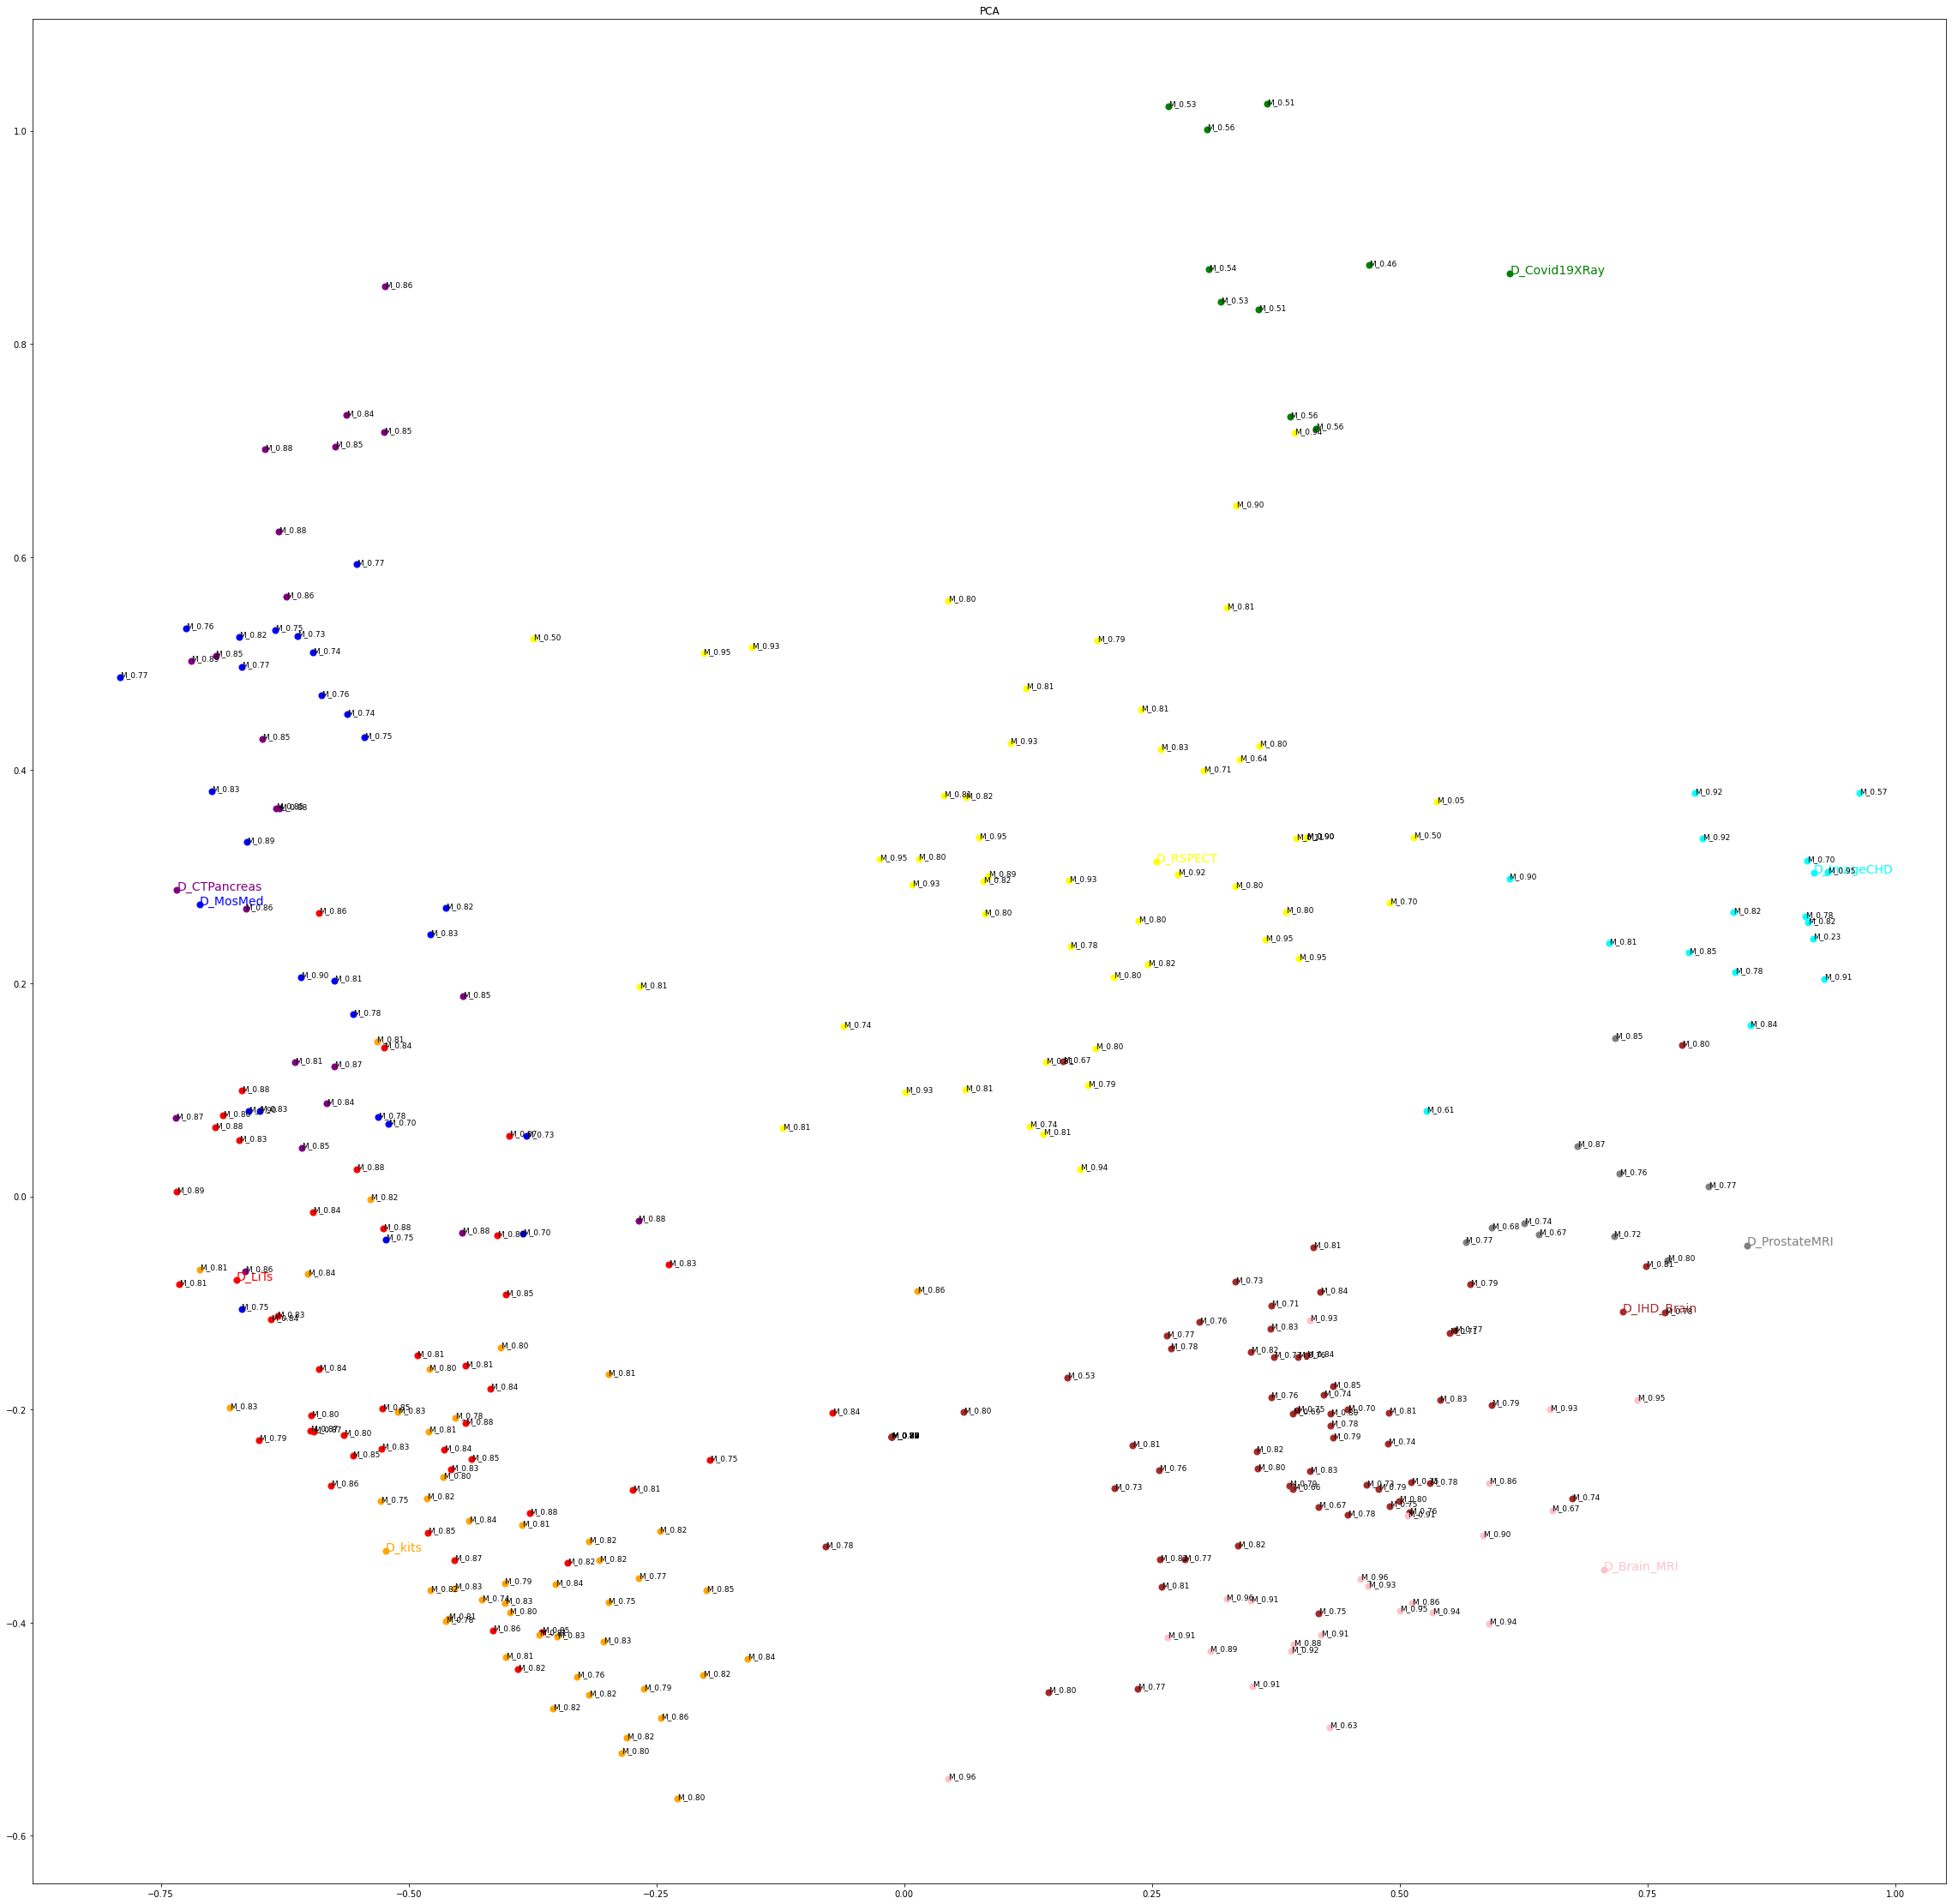

In [303]:
# PCA Visualization
visualize_embeddings(data_emb_list, 'PCA', 'pca', return_emb=False)

# LLE Visualization
visualize_embeddings(data_emb_list, 'LLE', 'lle', return_emb=False)


/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 327 samples in 0.001s...
[t-SNE] Computed neighbors for 327 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 327 / 327
[t-SNE] Mean sigma: 0.331683
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.726368
[t-SNE] KL divergence after 300 iterations: 0.384009


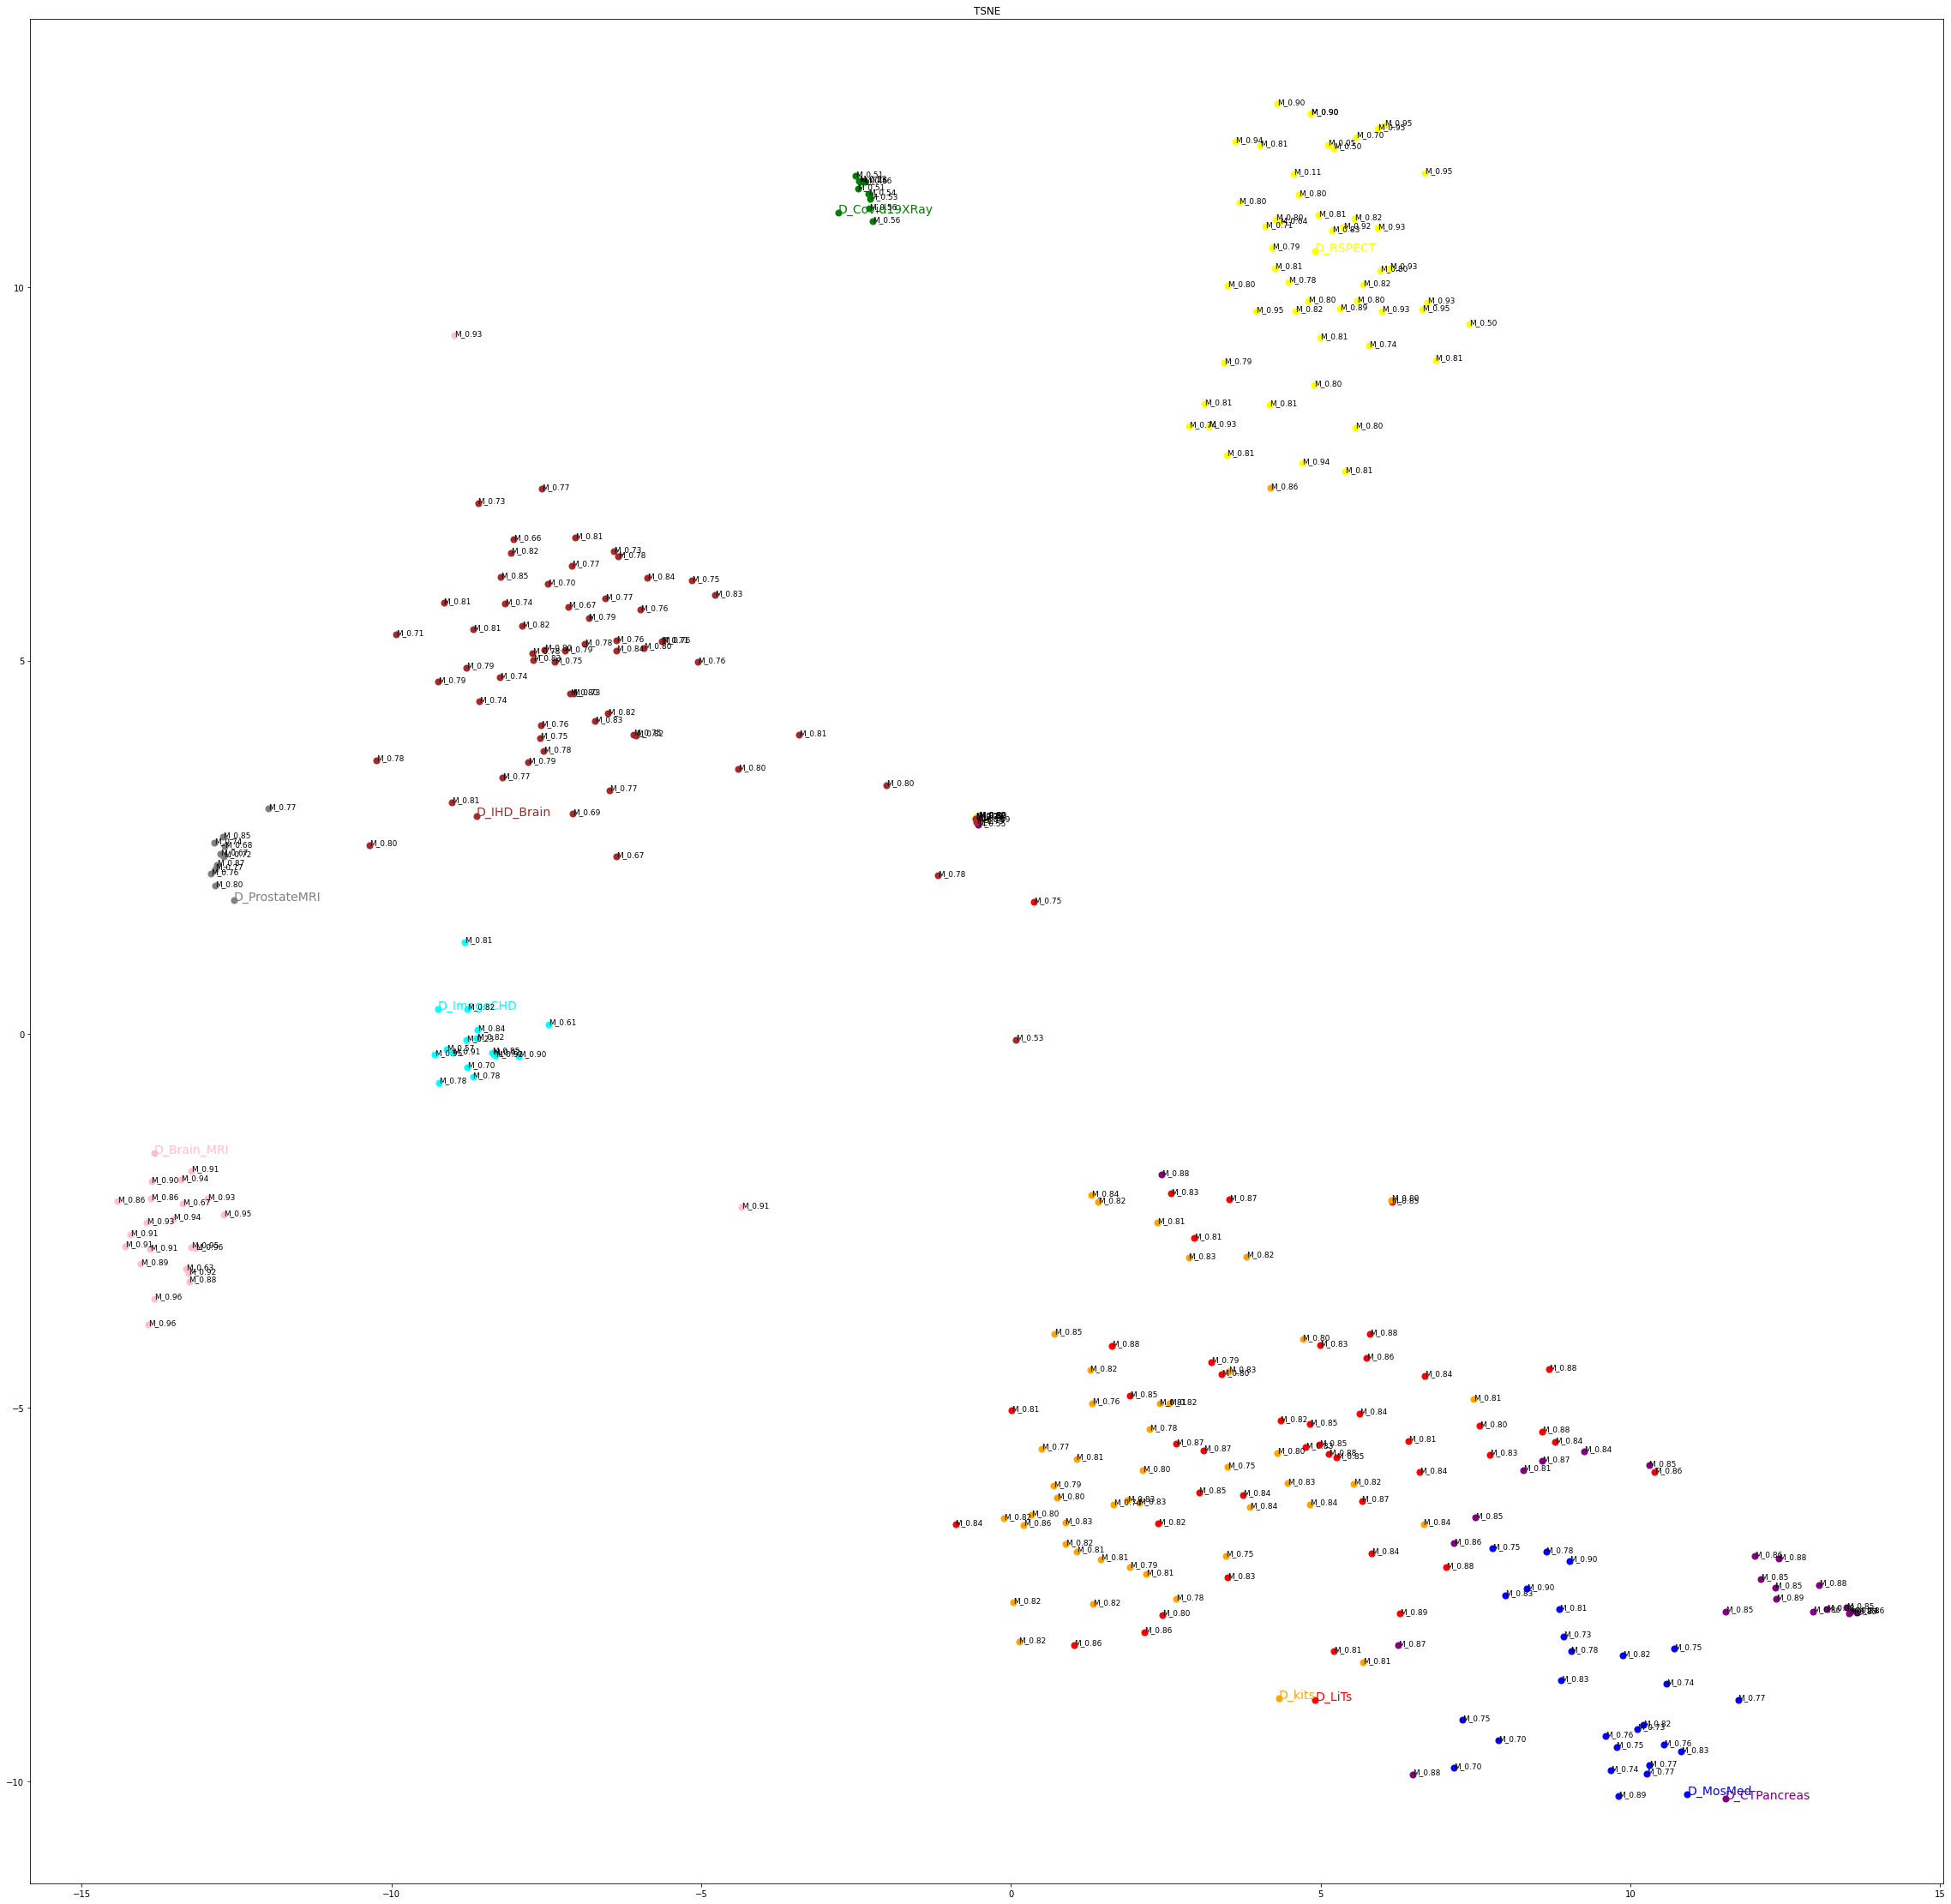

In [302]:
# TSNE Visualization
visualize_embeddings(data_emb_list, 'TSNE', 'tsne', return_emb=False)

# Isomap Visualization
visualize_embeddings(data_emb_list, 'Isomap', 'isomap', return_emb=False)

In [ ]:
# Use plotly to plot the distance matrix as a force directed graph
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_distance_matrix(distances, labels):
    # Create a trace
    trace = go.Heatmap(z=distances,
                       x=labels,
                       y=labels,
                       colorscale='Jet')
    data = [trace]
    # Plot and embed in ipython notebook!
    iplot(data, filename='labels')


# Plot the distance matrix for the true embedding
plot_distance_matrix(true_distances, true['name'])
